# Neural Network with PyTorch

Using PyTorch to implement and train neural networks:

http://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py



In [1]:
# As usual, a bit of setup
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
import platform
import torch

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

print("Python version: ", platform.python_version())

Python version:  3.6.4


## torch.nn

Neural networks can be constructed using the torch.nn package. nn depends on autograd to define models and differentiate them. An nn.Module contains layers, and a method forward(input)that returns the output.

We define a Module by subclassing nn.Module and defining a forward which receives input Variables and produces output Variables using other modules or other autograd operations on Variables.

In this example we implement the following CNN:

Conv-ReLU-Maxpool-Conv-ReLU-Maxpool-FC-ReLU-FC-ReLU-FC  

Net(  
  (conv1): Conv2d (1, 6, kernel_size=(5, 5), stride=(1, 1))
  (ReLU)
  (maxpool)
  (conv2): Conv2d (6, 16, kernel_size=(5, 5), stride=(1, 1))
  (ReLU
  (maxpool)
  (fc1): Linear(in_features=400, out_features=120)  
  (fc2): Linear(in_features=120, out_features=84)  
  (fc3): Linear(in_features=84, out_features=10)  
)  


In [2]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

# The neural net is defined as a class
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
print(net)

Net(
  (conv1): Conv2d (1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d (6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120)
  (fc2): Linear(in_features=120, out_features=84)
  (fc3): Linear(in_features=84, out_features=10)
)


## Forward Function

You have to define the forward function to implement the neural network. You can use any of the Tensor operations in the forward function. Once you have defined the forward function, the backward function is automatically defined  for you using autograd.

The learnable parameters of a model are returned by net.parameters() or net.named_parameters. You can use it to get the number of parameters of your whole model or its layers. 


In [3]:
print ("The total number of parameters:", sum([param.nelement() for param in net.parameters()]))

for name, param in net.named_parameters():
    print (name)
    print (param.nelement())

The total number of parameters: 61706
conv1.weight
150
conv1.bias
6
conv2.weight
2400
conv2.bias
16
fc1.weight
48000
fc1.bias
120
fc2.weight
10080
fc2.bias
84
fc3.weight
840
fc3.bias
10


## Input and Output

The input to the forward is an autograd.Variable, and so is the output.

Note that torch.nn only supports mini-batches The entire torch.nn package only supports inputs that are a mini-batch of samples, and not a single sample. For example, nn.Conv2d will take in a 4D Tensor of nSamples x nChannels x Height x Width. If you have a single sample, just use input.unsqueeze(0) to add a fake batch dimension.

Zero the gradient buffers of all parameters and backprops with random gradients:


In [4]:
# forward()
input = Variable(torch.randn(1, 1, 32, 32))   # Conv module expect this 4D array format
out = net(input)
print(out)

# backward()
net.zero_grad()  # zero the gradient as a good practice before the backward function
# You can perform a backward on a non-scalar output by having a gradient as argument
out.backward(torch.randn(1, 10))  

# Adding fake dimensions to samples
sample = torch.randn(32,32)
print (sample.size())
print (sample.unsqueeze(0).unsqueeze(0).size())  # This is how to add fake batch dimensions

Variable containing:
-0.1109 -0.0968 -0.0912 -0.0050  0.0968 -0.0850 -0.0553 -0.0508 -0.0166  0.0501
[torch.FloatTensor of size 1x10]

torch.Size([32, 32])
torch.Size([1, 1, 32, 32])


## Recap

Recap:

* **torch.Tensor** - A multi-dimensional array.
* **autograd.Variable**  - Wraps a Tensor and records the history of operations applied to it. Has the same API as a Tensor, with some additions like backward(). Also holds the gradient w.r.t. the tensor.
* **nn.Module** - Neural network module. Convenient way of encapsulating parameters, with helpers for moving them to GPU, exporting, loading, etc.
* **nn.Parameter** - A kind of Variable, that is automatically registered as a parameter when assigned as an attribute to a Module.
* **autograd.Function** - Implements forward and backward definitions of an autograd operation. Every Variable operation, creates at least a single Function node, that connects to functions that created a Variable and encodes its history.

## Loss Function

There are several different loss functions under the nn package . A simple loss is: nn.MSELoss which computes the mean-squared error between the input and the target.


In [6]:
output = net(input)
print (output)
target = Variable(torch.arange(1, 11))  # a dummy target, for example
print (target)
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)


Variable containing:
-0.1109 -0.0968 -0.0912 -0.0050  0.0968 -0.0850 -0.0553 -0.0508 -0.0166  0.0501
[torch.FloatTensor of size 1x10]

Variable containing:
  1
  2
  3
  4
  5
  6
  7
  8
  9
 10
[torch.FloatTensor of size 10]

Variable containing:
 38.7188
[torch.FloatTensor of size 1]



If you follow loss in the backward direction, using it’s .grad_fn attribute, you will see a graph of computations that looks like this:

input -> conv2d -> relu -> maxpool2d -> conv2d -> relu -> maxpool2d  
      -> view -> linear -> relu -> linear -> relu -> linear  
      -> MSELoss  
      -> loss  
      
So, when we call loss.backward(), the whole graph is differentiated w.r.t. the loss, and all Variables in the graph will have their .grad Variable accumulated with the gradient.

In [16]:
print(loss.grad_fn)  # MSELoss
print(loss.grad_fn.next_functions[0][0])  # Linear
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])  # ReLU
print(loss.grad_fn.next_functions[0][0].next_functions[0][0].next_functions[0][0])  # ???


## Backprop

To backpropagate the error all we have to do is to loss.backward(). **You need to clear the existing gradients though, else gradients will be accumulated to existing gradients**.

Below we call loss.backward(), and have a look at conv1’s bias gradients before and after the backward.

In [17]:
net.zero_grad()     # zeroes the gradient buffers of all parameters

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
Variable containing:
 0
 0
 0
 0
 0
 0
[torch.FloatTensor of size 6]

conv1.bias.grad after backward
Variable containing:
 0.0612
-0.0543
-0.0343
 0.1072
-0.0155
 0.0497
[torch.FloatTensor of size 6]



## Update Weights

The simplest update rule used in practice is the Stochastic Gradient Descent (SGD):  

weight = weight - learning_rate * gradient  

torch.optim that implements update rules such as SGD, Nesterov-SGD, Adam, RMSProp, etc. Using it is very simple:


In [19]:
learning_rate = 0.01

# SGD
for f in net.parameters():
    f.data.sub_(f.grad.data * learning_rate)
    
import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)

# in your training loop:
optimizer.zero_grad()   # zero the gradient buffers
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step()    # Does the update

# Training a Classifier

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using torchvision
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data


## 1. Load and normalizing the CIFAR10 training and test datasets using torchvision

Specifically for vision, there is a package called torchvision, that has data loaders for common datasets such as Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz., torchvision.datasets and torch.utils.data.DataLoader.

In [21]:
import torch
import torchvision
import torchvision.transforms as transforms

# The output of torchvision datasets are PILImage images of range [0, 1]. 
# We transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

 # batch size defines the number of images and labels loaded per iteration
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,  
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


Size of CFAR10 Train Set:  50000
  cat truck  bird truck


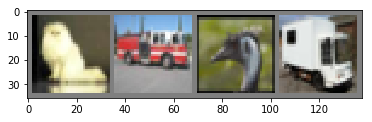

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

print ("Size of CFAR10 Train Set: ", len(trainset))
    
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 2. Define a Convolution Neural Network

Copy the neural network from the Neural Networks section before and modify it to take 3-channel images (instead of 1-channel images as it was defined).

In [23]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

## 3. Define a Loss function and optimizer

In [24]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 4. Train the network

We simply have to loop over our data iterator, and feed the inputs to the network and optimize.

In [25]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.223
[1,  4000] loss: 1.857
[1,  6000] loss: 1.675
[1,  8000] loss: 1.572
[1, 10000] loss: 1.520
[1, 12000] loss: 1.476
[2,  2000] loss: 1.420
[2,  4000] loss: 1.383
[2,  6000] loss: 1.344
[2,  8000] loss: 1.312
[2, 10000] loss: 1.310
[2, 12000] loss: 1.266
Finished Training


## 5. Test the network on the test data

We need to check if the network has learnt anything at all. We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.

Size of CFAR10 Test Set:  10000
The labels: 
 3
 8
 8
 0
[torch.LongTensor of size 4]

GroundTruth:    cat  ship  ship plane
The predictions: 
 3
 8
 0
 0
[torch.LongTensor of size 4]

Predicted:    cat  ship plane plane


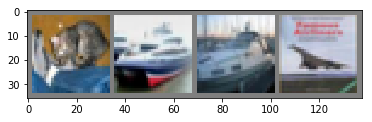

In [40]:
print ("Size of CFAR10 Test Set: ", len(testset))
dataiter = iter(testloader)
images, labels = dataiter.next()

print ("The labels:",labels.squeeze())  

# print images
imshow(torchvision.utils.make_grid(images))
# print ground truth
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

# Use CNN to predict class
outputs = net(Variable(images))
_, predicted = torch.max(outputs.data, 1)
print ("The predictions:",predicted)
# print prediction
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))


Let us look at how the network performs on the whole dataset.

In [34]:
correct = 0
total = 0

for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %


What are the classes that performed well, and the classes that did not perform well:

In [41]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()  # flattens the list
    
    for i in range(4):  # The loader is defined so that it loads 4 images/labels per iteration
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 66 %
Accuracy of   car : 54 %
Accuracy of  bird : 25 %
Accuracy of   cat : 51 %
Accuracy of  deer : 42 %
Accuracy of   dog : 41 %
Accuracy of  frog : 54 %
Accuracy of horse : 67 %
Accuracy of  ship : 66 %
Accuracy of truck : 79 %


# The REAL DEAL

We will do this for real!!! But the setup above is not ideal. We will move towards the CS231N startup codes instead.